In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataRep = '../data/'
datasetRep = '../data/dataset/'

unicodeData = pd.read_csv(dataRep+'unicode_translation.csv')
trainData = pd.read_csv(dataRep+'train.csv')
sampleSubData = pd.read_csv(dataRep+'sample_submission.csv')

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [3]:
def makeSquareImage(im, minSize=32, fill_color=(0, 0, 0)):
    x, y = im.size
    size = max(max(x, y), minSize)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def convertImage(image, xpixel=1024, ypixel=1024, gray=False):
    #convert size
    image.thumbnail([xpixel, ypixel], Image.LANCZOS)
    image.convert('RGB')
    image = makeSquareImage(image, minSize=max(xpixel, ypixel), fill_color=(255,255,255))
    
    #convert color
    if gray:
        image.convert('L')
        
    return image


def createCaracDatabase(label):
    carac = []
    pos = []
    size = []
    if(not isinstance(label, float)):
        labelS = label.split()
        for i in range(0, len(labelS), 5):
            carac.append(unicodeData[unicodeData['Unicode']==labelS[i]]['char'].iloc[0])
            pos.append((int(labelS[i+1]),int(labelS[i+2])))
            size.append((int(labelS[i+3]),int(labelS[i+4])))
    
    return pd.DataFrame(list(zip(carac, pos, size)), columns=['caracter', 'position', 'size'])
    
    
def extractCaracterFromImage(image, pos, size, finalSize=(32,32), gray=False):
    box = (pos[0], pos[1], pos[0]+size[0], pos[1]+size[1])
    return convertImage(image.copy().crop(box), xpixel=finalSize[0], ypixel=finalSize[0], gray=gray)


def fromPageCreateCaracterDataset(image, label):
    caracDB = createCaracDatabase(label)
    imageCaracList = []
    caracList = []
    for i in range(0, len(caracDB)):
        caracList.append(caracDB.iloc[i]['caracter'])
        if (caracDB.iloc[i]['size'][0] > 0) and (caracDB.iloc[i]['size'][1] > 0):
            imArray = np.asarray(extractCaracterFromImage(image, caracDB.iloc[i]['position'], caracDB.iloc[i]['size'])).copy()
            imArray = (np.sum(imArray, axis=2)/3.).astype(np.uint8)
            imageCaracList.append(imArray.tolist())
        else:
            print('error')
    return caracList, imageCaracList


def createDatasetFirstNetwork(xpixel=1024, ypixel=1024, gray=False):
    nImage = trainData.shape[0]
    
    i=0
    print('Convert train image')
    print('\n')
    for idImage in trainData['image_id']:
        i+=1
        update_progress(float(i)/float(nImage))
        image = Image.open(dataRep+'train_images/'+idImage+'.jpg')
        image = convertImage(image,xpixel, ypixel, gray)
        image.save(datasetRep+'train/'+idImage+'.jpg')
        

def createDatasetSecondNetwork():
    nImage = trainData.shape[0]
    #nImage = 10
    imageCaracList = []
    caracList = []
    
    print('Convert train image')
    print('\n')
    for j in range(0, nImage):
        update_progress(float(j+1)/float(nImage))
        idImage = trainData['image_id'].iloc[j]
        label = trainData['labels'].iloc[j]
        image = Image.open(dataRep+'train_images/'+idImage+'.jpg')
        tmp1, tmp2 = fromPageCreateCaracterDataset(image, label)
        caracList += tmp1
        imageCaracList += tmp2
        
    caracList = np.asarray(caracList)
    imageCaracList = np.asarray(imageCaracList, dtype=np.uint8)
    np.savez_compressed(datasetRep+'caracterClassification.npz', caracter = caracList, image = imageCaracList)
    del imageCaracList
    del caracList

In [4]:
createDatasetSecondNetwork()

Progress: [####################] 100.0%


(683464, 32, 32) (683464,) (4212,)
['0' '?' '■' ... '𩞀' '𩷚' '𩹵']


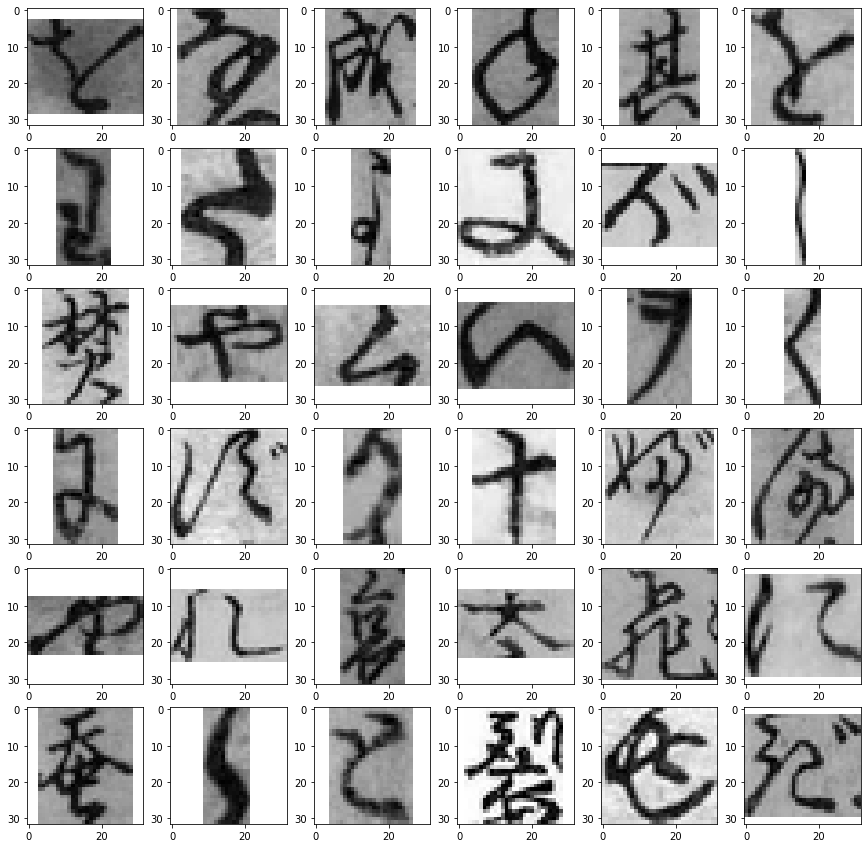

In [6]:
raw = np.load('../data/dataset/caracterClassification.npz')

nDisp = 6
imageId = np.random.randint(raw['image'].shape[0], size=(nDisp, nDisp))
print(raw['image'].shape, raw['caracter'].shape, np.unique(raw['caracter']).shape)
print(np.unique(raw['caracter']))

plt.figure(figsize=(15,15))
for i in range(nDisp):
    for j in range(nDisp):
        plt.subplot(nDisp, nDisp, i*nDisp+j+1)
        plt.imshow(raw['image'][imageId[i,j],:,:], cmap='gist_gray')
plt.show()

In [9]:
raw['image'].nbytes/1024/1024

667.4453125

In [10]:
raw['caracter'].nbytes/1024/1024

2.607208251953125